In [61]:
DATASET_DIR = ''
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K

environment='L'


In [62]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [63]:


X = pd.read_csv(os.path.join(DATASET_DIR, 'essay_set1_merged.csv'), encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
print(X.columns)
#y = X[[ 'domain1_score', 'Content',
#       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]

X = X.dropna(axis=1)
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")


Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')


Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [64]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [65]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.models import Model

def get_model():
    """Define the model.""" 
    inputs = Input(shape=(1, 300))
    extract = LSTM(300, return_sequences=True)(inputs)
    class11 = LSTM(64)(extract)
    output1 = Dense(7, activation='sigmoid')(class11)
    output2 = Dense(7, activation='sigmoid')(class11)
    output3 = Dense(7, activation='sigmoid')(class11)
    output4 = Dense(7, activation='sigmoid')(class11)
    output5 = Dense(7, activation='sigmoid')(class11)
    output6 = Dense(7, activation='sigmoid')(class11)

    model = Model(inputs=inputs,outputs=[output1,output2,output3])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.

(1783, 9)


Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs(1783, 300)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 300)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 300)       721200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           93440       lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 7)            455         lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (D

Train on 1426 samples, validate on 357 samples
Epoch 1/3


  64/1426 [>.............................] - ETA: 37s - loss: 1.3862 - dense_1_loss: 0.6931 - dense_2_loss: 0.6931 - dense_1_acc: 0.5580 - dense_2_acc: 0.5223

 192/1426 [===>..........................] - ETA: 11s - loss: 1.3823 - dense_1_loss: 0.6913 - dense_2_loss: 0.6910 - dense_1_acc: 0.7567 - dense_2_acc: 0.7433

 320/1426 [=====>........................] - ETA: 6s - loss: 1.3781 - dense_1_loss: 0.6893 - dense_2_loss: 0.6888 - dense_1_acc: 0.7969 - dense_2_acc: 0.7888 

 448/1426 [========>.....................] - ETA: 4s - loss: 1.3733 - dense_1_loss: 0.6870 - dense_2_loss: 0.6863 - dense_1_acc: 0.8141 - dense_2_acc: 0.8084

 576/1426 [===========>..................] - ETA: 2s - loss: 1.3678 - dense_1_loss: 0.6844 - dense_2_loss: 0.6834 - dense_1_acc: 0.8237 - dense_2_acc: 0.8192

 704/1426 [=============>................] - ETA: 2s - loss: 1.3611 - dense_1_loss: 0.6813 - dense_2_loss: 0.6799 - dense_1_acc: 0.8297 - dense_2_acc: 0.8261

 832/1426 [================>.............] - ETA: 1s - loss: 1.3536 - dense_1_loss: 0.6777 - dense_2_loss: 0.6760 - dense_1_acc: 0.8340 - dense_2_acc: 0.8309

 960/1426 [===================>..........] - ETA: 1s - loss: 1.3448 - dense_1_loss: 0.6735 - dense_2_loss: 0.6714 - dense_1_acc: 0.8371 - dense_2_acc: 0.8344

1088/1426 [=====================>........] - ETA: 0s - loss: 1.3344 - dense_1_loss: 0.6685 - dense_2_loss: 0.6659 - dense_1_acc: 0.8394 - dense_2_acc: 0.8371

1216/1426 [========================>.....] - ETA: 0s - loss: 1.3225 - dense_1_loss: 0.6628 - dense_2_loss: 0.6597 - dense_1_acc: 0.8413 - dense_2_acc: 0.8392

1344/1426 [===========================>..] - ETA: 0s - loss: 1.3091 - dense_1_loss: 0.6562 - dense_2_loss: 0.6528 - dense_1_acc: 0.8428 - dense_2_acc: 0.8409

1426/1426 [==============================] - 3s 2ms/step - loss: 1.2991 - dense_1_loss: 0.6515 - dense_2_loss: 0.6476 - dense_1_acc: 0.8436 - dense_2_acc: 0.8418 - val_loss: 1.0921 - val_dense_1_loss: 0.5491 - val_dense_2_loss: 0.5430 - val_dense_1_acc: 0.8571 - val_dense_2_acc: 0.8571


Epoch 2/3
  64/1426 [>.............................] - ETA: 0s - loss: 1.0899 - dense_1_loss: 0.5489 - dense_2_loss: 0.5410 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.0651 - dense_1_loss: 0.5368 - dense_2_loss: 0.5282 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.0343 - dense_1_loss: 0.5223 - dense_2_loss: 0.5120 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.0025 - dense_1_loss: 0.5057 - dense_2_loss: 0.4968 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 0.9731 - dense_1_loss: 0.4905 - dense_2_loss: 0.4826 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 0.9445 - dense_1_loss: 0.4748 - dense_2_loss: 0.4697 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 0.9179 - dense_1_loss: 0.4605 - dense_2_loss: 0.4574 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 0.8937 - dense_1_loss: 0.4478 - dense_2_loss: 0.4458 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 0.8718 - dense_1_loss: 0.4355 - dense_2_loss: 0.4363 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 0.8505 - dense_1_loss: 0.4234 - dense_2_loss: 0.4272 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 0.8330 - dense_1_loss: 0.4138 - dense_2_loss: 0.4192 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

1426/1426 [==============================] - 1s 502us/step - loss: 0.8225 - dense_1_loss: 0.4073 - dense_2_loss: 0.4152 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - val_loss: 0.6483 - val_dense_1_loss: 0.2951 - val_dense_2_loss: 0.3531 - val_dense_1_acc: 0.8571 - val_dense_2_acc: 0.8571


Epoch 3/3
  64/1426 [>.............................] - ETA: 0s - loss: 0.6401 - dense_1_loss: 0.3078 - dense_2_loss: 0.3323 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 0.6525 - dense_1_loss: 0.3162 - dense_2_loss: 0.3363 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 0.6452 - dense_1_loss: 0.3085 - dense_2_loss: 0.3367 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 0.6468 - dense_1_loss: 0.3099 - dense_2_loss: 0.3369 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 0.6408 - dense_1_loss: 0.3069 - dense_2_loss: 0.3339 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 0.6292 - dense_1_loss: 0.2995 - dense_2_loss: 0.3297 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 0.6301 - dense_1_loss: 0.3010 - dense_2_loss: 0.3291 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 0.6300 - dense_1_loss: 0.2997 - dense_2_loss: 0.3303 - dense_1_acc: 0.8557 - dense_2_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 0.6296 - dense_1_loss: 0.3007 - dense_2_loss: 0.3289 - dense_1_acc: 0.8541 - dense_2_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 0.6272 - dense_1_loss: 0.2991 - dense_2_loss: 0.3281 - dense_1_acc: 0.8544 - dense_2_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 0.6250 - dense_1_loss: 0.2968 - dense_2_loss: 0.3282 - dense_1_acc: 0.8559 - dense_2_acc: 0.8571

1426/1426 [==============================] - 1s 486us/step - loss: 0.6236 - dense_1_loss: 0.2962 - dense_2_loss: 0.3273 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - val_loss: 0.6177 - val_dense_1_loss: 0.2789 - val_dense_2_loss: 0.3388 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571


dict_keys(['dense_1_loss', 'val_dense_2_acc', 'loss', 'dense_2_loss', 'val_dense_1_loss', 'val_dense_2_loss', 'val_loss', 'dense_1_acc', 'val_dense_1_acc', 'dense_2_acc'])


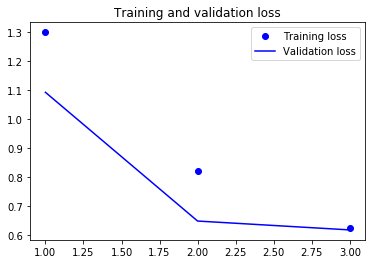

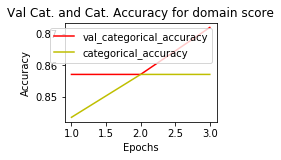

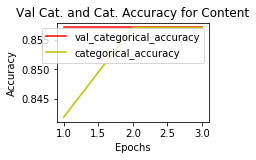

In [66]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

'''
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
'''

K.clear_session()

results = []
y_pred_list = []

count = 1
print(X.shape)
train_essays = X['essay']

sentences = []
for essay in train_essays:
        sentences += essay_to_sentences(essay, remove_stopwords = True)
        
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays = []

# Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

trainDataVecs = np.array(trainDataVecs)
print("trainDataVecs"+str(trainDataVecs.shape))

trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
validsiz=200

'''
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
'''

y_domain_score = to_categorical(y_domain_score)
y_content = to_categorical(y_content)
y_organization = to_categorical(y_organization)
y_wordChoice = to_categorical(y_wordChoice)
y_sentenceFluency = to_categorical(y_sentenceFluency)
y_conventions = to_categorical(y_conventions)

lstm_model = get_model()
history = lstm_model.fit(trainDataVecs, y=[y_domain_score,y_content,y_organization] ,validation_split=0.2
                         ,batch_size=64, epochs=3)

print(history.history.keys())

if count == 1:
     lstm_model.save('final_lstm.h5')

import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.subplot(222)
valacc = history.history['val_dense_1_acc']
acc = history.history['dense_1_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for domain score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(223)
valacc = history.history['val_dense_2_acc']
acc = history.history['dense_2_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(224)
valacc = history.history['val_dense_2_acc']
acc = history.history['dense_2_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#break
count += 1


In [43]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[1.8432736e-04, 6.3183904e-04, 5.1012635e-04, 2.4204850e-03,
        1.3749599e-03, 2.3709595e-02, 3.4940720e-02, 3.2466865e-01,
        2.4821348e-01, 2.5709864e-01, 8.0462538e-02, 2.5904387e-02]],
      dtype=float32)

In [45]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "rater1_domain1",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')
